## Aviso
Este notebook tem caráter exploratório e analítico. Ele foi criado para um trabalho de faculdade em out/24, inicialmente, era somente um notebook no Google Colab. Foi atualizado para praticar orquestração dos dados, buscando refletir um ambiente mais profissional.

O pipeline produtivo do projeto está implementado em `/src` e `/pipelines`.



## Modelo Preditor de acidentes

O presente notebook tem por objetivo analisar os dados abertos dos acidentes registrados em 2023 pela PRF (Policia Rodoviária Federal) e, com base nos insight extraídos dos dados criar um modelo capaz de prever se um acidente vai resultar em um óbito com base em dados fornecidos.



# imports

In [ ]:
import pandas as pd # utilizado para manipular o dataframe
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Dicionário de dados

* id: Variável com valores numéricos, representando o identificador do
acidente.
* data_inversa: Data da ocorrência no formato dd/mm/aaaa.
* dia_semana: Dia da semana da ocorrência. Ex.: Segunda, Terça, etc.
* horario: Horário da ocorrência no formato hh:mm:ss.
* uf: Unidade da Federação. Ex.: MG, PE, DF, etc.
* br: Variável com valores numéricos representando o identificador da
BR do acidente.
* municipio: Nome do município de ocorrência do acidente.
* causa_acidente: Identificação da causa presumível do acidente. Ex.: Falta de
atenção, Velocidade incompatível, etc.
* tipo_acidente: Identificação do tipo de acidente. Ex.: Colisão frontal, Saída de
pista, etc.
* classificação_acidente: Classificação quanto à gravidade do acidente: Sem Vítimas, Com Vítimas Feridas, Com Vítimas Fatais e Ignorado.
* fase_dia: Fase do dia no momento do acidente. Ex. Amanhecer, Pleno dia,etc.
* sentido_via: Sentido da via considerando o ponto de colisão: Crescente e
decrescente.
* condição_meteorologica:Condição meteorológica no momento do acidente: Céu claro,
chuva, vento, etc.
* tipo_pista: Tipo da pista considerando a quantidade de faixas: Dupla,simples
ou múltipla.
* tracado_via: Descrição do traçado da via: reta, curva ou cruzamento.
* uso_solo: Descrição sobre as características do local do acidente:Urbano ou rural.
* mortos: Total de pessoas mortas envolvidas na ocorrência.
* feridos_leves: Total de pessoas com ferimentos leves envolvidas na ocorrência.
* feridos_graves: Total de pessoas com ferimentos graves envolvidas na ocorrência.
* Ilesos: Total de pessoas ilesas envolvidas na ocorrência.
* veiculos: Total de veículos envolvidos na ocorrência.

Dicionário retirado diretamente do site PRF: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos

# Leitura do arquivo

O arquivo csv da PRF não estava codificado em UTF-8, que é o padrão do python e da biblioteca Pandas. Por a necessidade especificar o enconding: enconding='latin-1'. Foi escolhido o 'latin-1' (ou ISO-8859-1) pois ele já abrange os caracteres especiais da língua portuguesa. Outra opção seria usar o 'windows-1252' como encoding. Essa codificação é um superconjunto do latin-1 (ou seja, inclui todos os caracteres do latin-1 mais alguns outros).

In [ ]:
df = pd.read_csv('/content/acidentes2023_todas_causas_tipos.csv', encoding='latin-1', delimiter=';', na_values=['NaN', 'NULL', 'na'])

# Tratamento dos Dados

In [ ]:
df.columns


Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo', 'marca',
       'ano_fabricacao_veiculo', 'tipo_envolvido', 'estado_fisico', 'idade',
       'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos',
       'latitude', 'longitude', 'regional', 'delegacia', 'uop'],
      dtype='object')

In [ ]:
df['data_inversa'] = pd.to_datetime(df['data_inversa'])
df['mes'] = df['data_inversa'].dt.month

In [ ]:
df = df.drop(columns=['id','horario', 'km', 'municipio', 'causa_principal','causa_acidente','ordem_tipo_acidente','sentido_via','ilesos', 'tipo_pista' ,'feridos_leves', 'feridos_graves', 'classificacao_acidente','latitude', 'longitude', 'regional', 'delegacia', 'uop', 'id_veiculo', 'data_inversa', 'pesid' ])

# Retirei colunas redundantes e/ou que eu não considero relevantes

In [ ]:
df.head()

,dia_semana,uf,br,tipo_acidente,fase_dia,condicao_metereologica,tracado_via,uso_solo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,estado_fisico,idade,sexo,mortos,mes
0,domingo,MG,116.0,Queda de ocupante de veículo,Plena Noite,Nublado,Reta,Sim,Motocicleta,HONDA/CB 250F TWISTER,2018.0,Condutor,Lesões Leves,24.0,Masculino,0.0,1
1,domingo,MG,116.0,Queda de ocupante de veículo,Plena Noite,Nublado,Reta,Sim,Motocicleta,HONDA/CB 250F TWISTER,2018.0,Condutor,Lesões Leves,24.0,Masculino,0.0,1
2,domingo,MG,116.0,Tombamento,Plena Noite,Nublado,Reta,Sim,Motocicleta,HONDA/CB 250F TWISTER,2018.0,Condutor,Lesões Leves,24.0,Masculino,0.0,1
3,domingo,MG,116.0,Tombamento,Plena Noite,Nublado,Reta,Sim,Motocicleta,HONDA/CB 250F TWISTER,2018.0,Condutor,Lesões Leves,24.0,Masculino,0.0,1
4,domingo,MG,381.0,Capotamento,Pleno dia,Garoa/Chuvisco,Curva,Não,Automóvel,GM/PRISMA MAXX,2009.0,Condutor,Lesões Leves,47.0,Masculino,0.0,1


In [ ]:
df.describe()

,br,ano_fabricacao_veiculo,idade,mortos,mes
count,569216.000000,550280.000000,465604.000000,515165.000000,571052.000000
mean,214.391231,1909.255675,39.737064,0.051541,6.669267
std,126.955001,444.040377,39.068798,0.221098,3.458990
min,10.000000,0.000000,0.000000,0.000000,1.000000
25%,116.000000,2007.000000,27.000000,0.000000,4.000000
50%,163.000000,2013.000000,38.000000,0.000000,7.000000
75%,324.000000,2019.000000,49.000000,0.000000,10.000000
max,498.000000,2023.000000,2022.000000,1.000000,12.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571052 entries, 0 to 571051
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dia_semana              571052 non-null  object 
 1   uf                      571052 non-null  object 
 2   br                      569216 non-null  float64
 3   tipo_acidente           571052 non-null  object 
 4   fase_dia                571052 non-null  object 
 5   condicao_metereologica  571052 non-null  object 
 6   tracado_via             571052 non-null  object 
 7   uso_solo                571052 non-null  object 
 8   tipo_veiculo            550280 non-null  object 
 9   marca                   571052 non-null  object 
 10  ano_fabricacao_veiculo  550280 non-null  float64
 11  tipo_envolvido          515165 non-null  object 
 12  estado_fisico           515165 non-null  object 
 13  idade                   465604 non-null  float64
 14  sexo                

In [ ]:
df['uso_solo'] = df['uso_solo'].replace({'Sim': 'Urbano', 'Não': 'Rural'})
display(df['uso_solo'].value_counts())

,count
uso_solo,
Rural,357639
Urbano,213413


In [ ]:
print("Análise dos tipos de dados e valores nulos")
df.info()

print("\nContagem de variáveis numéricas:")
numeric_cols = df.select_dtypes (include=['number']).columns
print(f"Número de variáveis numéricas: {len(numeric_cols)}")

print("\nContagem de variáveis categóricas:")
categorical_cols = df.select_dtypes (include=['object']).columns
print(f"Número de variáveis categóricas: {len(categorical_cols)}")

Análise dos tipos de dados e valores nulos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571052 entries, 0 to 571051
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dia_semana              571052 non-null  object 
 1   uf                      571052 non-null  object 
 2   br                      569216 non-null  float64
 3   tipo_acidente           571052 non-null  object 
 4   fase_dia                571052 non-null  object 
 5   condicao_metereologica  571052 non-null  object 
 6   tracado_via             571052 non-null  object 
 7   uso_solo                571052 non-null  object 
 8   tipo_veiculo            550280 non-null  object 
 9   marca                   571052 non-null  object 
 10  ano_fabricacao_veiculo  550280 non-null  float64
 11  tipo_envolvido          515165 non-null  object 
 12  estado_fisico           515165 non-null  object 
 13  idade                   465604 

In [ ]:
df.isnull().sum()

,0
dia_semana,0
uf,0
br,1836
tipo_acidente,0
fase_dia,0
condicao_metereologica,0
tracado_via,0
uso_solo,0
tipo_veiculo,20772
marca,0


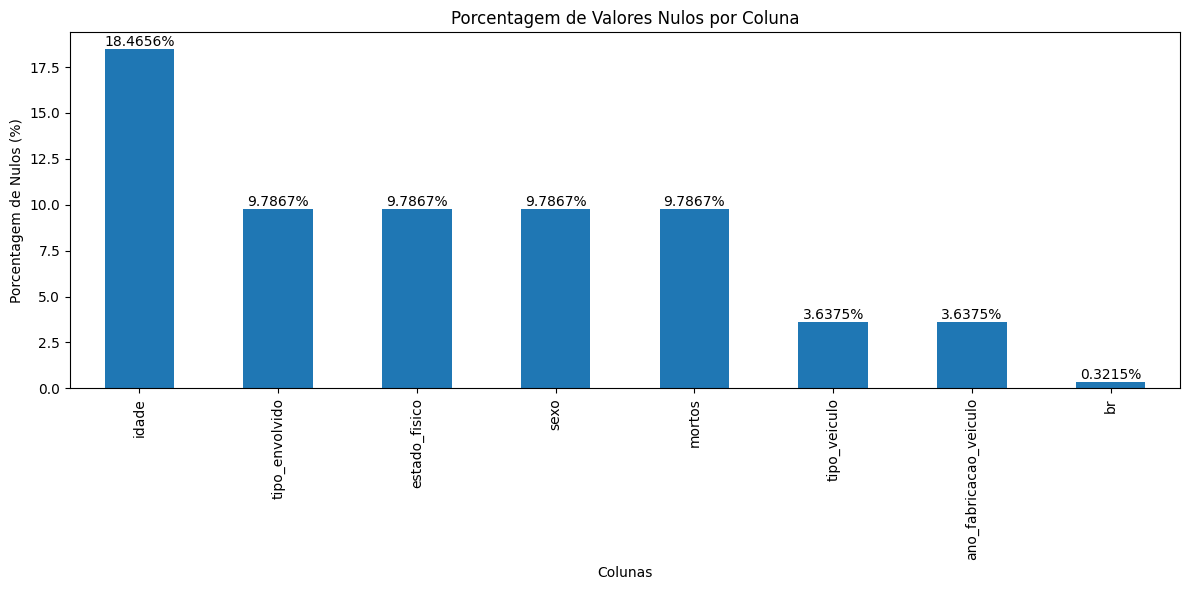

In [ ]:
#Contagem de valores nulos por coluna

null_counts = df.isnull().sum()

null_percentages = (null_counts / len(df)) * 100

plt.figure(figsize=(12, 6))
ax = null_percentages[null_percentages > 0].sort_values(ascending=False).plot(kind='bar')
plt.title('Porcentagem de Valores Nulos por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Porcentagem de Nulos (%)')
plt.xticks(rotation=90)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f%%')

plt.tight_layout()
plt.show()

In [ ]:
null_counts

,0
dia_semana,0
uf,0
br,1836
tipo_acidente,0
fase_dia,0
condicao_metereologica,0
tracado_via,0
uso_solo,0
tipo_veiculo,20772
marca,0


In [ ]:
df.dropna(subset=['br'], inplace=True)#Remover os valores nulos da coluna br

#Os valores nulos são preenchidos com a mediana da respectiva coluna.
for col in ['ano_fabricacao_veiculo', 'idade']:
    df[col] = df[col].fillna(df[col].median())

# Os valores nulos são preenchidos usando o método (forward fill)
for col in ['tipo_veiculo', 'sexo', 'mortos', 'estado_fisico']:
    df[col] = df[col].ffill()

# Preenche os valores vazios com a moda de cada coluna
for col in ['tipo_envolvido']:
    # Calculate mode and fill NaN, handling potential multiple modes by taking the first one
    mode_value = df[col].mode()[0] if not df[col].mode().empty else None
    if mode_value is not None:
        df[col] = df[col].fillna(mode_value)

print("Valores vazios preenchidos.")

Valores vazios preenchidos.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 569216 entries, 0 to 571051
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dia_semana              569216 non-null  object 
 1   uf                      569216 non-null  object 
 2   br                      569216 non-null  float64
 3   tipo_acidente           569216 non-null  object 
 4   fase_dia                569216 non-null  object 
 5   condicao_metereologica  569216 non-null  object 
 6   tracado_via             569216 non-null  object 
 7   uso_solo                569216 non-null  object 
 8   tipo_veiculo            569216 non-null  object 
 9   marca                   569216 non-null  object 
 10  ano_fabricacao_veiculo  569216 non-null  float64
 11  tipo_envolvido          569216 non-null  object 
 12  estado_fisico           569216 non-null  object 
 13  idade                   569216 non-null  float64
 14  sexo                    5

In [ ]:
null_counts = df.isnull().sum()

print("Valores nulos após o filtro:")
print(null_counts)

Valores nulos após o filtro:
dia_semana                0
uf                        0
br                        0
tipo_acidente             0
fase_dia                  0
condicao_metereologica    0
tracado_via               0
uso_solo                  0
tipo_veiculo              0
marca                     0
ano_fabricacao_veiculo    0
tipo_envolvido            0
estado_fisico             0
idade                     0
sexo                      0
mortos                    0
mes                       0
dtype: int64


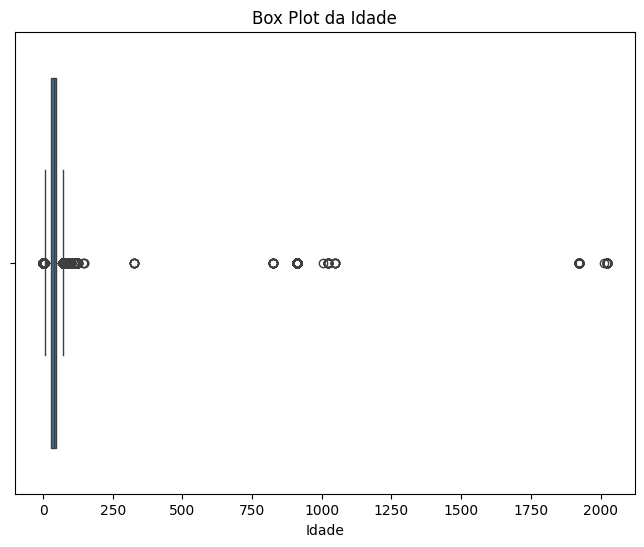

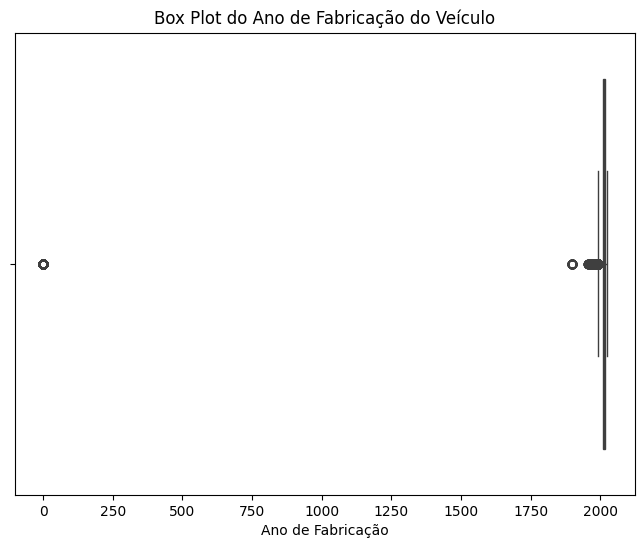

In [ ]:
# Box plot para a coluna 'idade'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['idade'])
plt.title('Box Plot da Idade')
plt.xlabel('Idade')
plt.show()

# Box plot para a coluna 'ano_fabricacao_veiculo'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['ano_fabricacao_veiculo'])
plt.title('Box Plot do Ano de Fabricação do Veículo')
plt.xlabel('Ano de Fabricação')
plt.show()

In [ ]:
df['idade'] = df.loc[(df['idade'] > 10) & (df['idade'] <= 70), 'idade']
df['ano_fabricacao_veiculo'] = df.loc[df['ano_fabricacao_veiculo'] >= 1995, 'ano_fabricacao_veiculo']

por algum motivo os anos de fabricação do veículo e da idade esão com valores absurdos. Isso já tinha sido notado pelo no describe. Foi usado um filtro para lidar com a situação.

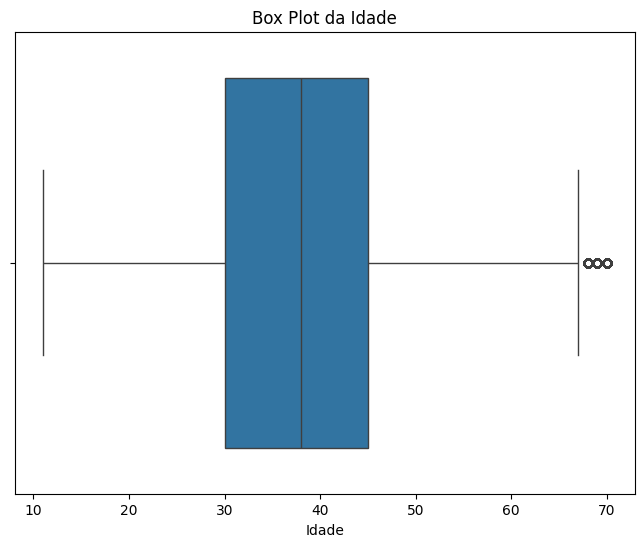

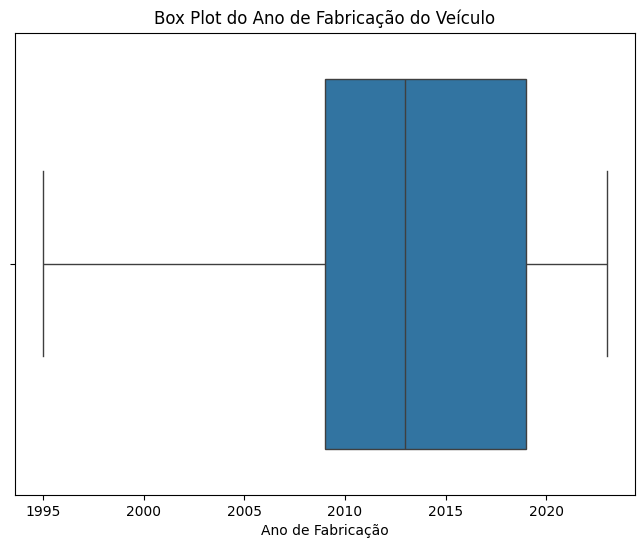

In [ ]:
# Box plot para a coluna 'idade'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['idade'])
plt.title('Box Plot da Idade')
plt.xlabel('Idade')
plt.show()

# Box plot para a coluna 'ano_fabricacao_veiculo'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['ano_fabricacao_veiculo'])
plt.title('Box Plot do Ano de Fabricação do Veículo')
plt.xlabel('Ano de Fabricação')
plt.show()

tratar idade e documentar por que escolheo o filtro pra cada coluna

# Análise exploratória

In [ ]:
target = df['mortos']

display(target)

,mortos
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
571047,0.0
571048,0.0
571049,0.0
571050,0.0


In [ ]:
#Verificando a distribuição da variável alvo 'mortos'
df['mortos'].value_counts()

,count
mortos,
0.0,538579
1.0,30637


In [ ]:
#Verificando se "óbito" tem a mesma frequência que mortos = 1
df['estado_fisico'].value_counts()

,count
estado_fisico,
Ileso,240595
Lesões Leves,189912
Lesões Graves,71377
Não Informado,36695
Óbito,30637


In [ ]:
#Definindo algumas variáveis para correlacionar com 'mortos'
variaveis = ['tipo_veiculo', 'dia_semana', 'fase_dia', 'condicao_metereologica','uso_solo','tipo_envolvido','sexo', 'uf','tipo_acidente','ano_fabricacao_veiculo','mes', 'idade']


In [ ]:
# Filtrando somente os casos em que houve óbito
df_obito = df[df['mortos'] == 1].copy()

# Separanda as colunas em variáveis categóricas e numéricas para comparar com os valores de mortos.
numerical_vars = ['ano_fabricacao_veiculo', 'idade', 'mes', 'br']
categorical_vars = [var for var in variaveis if var not in numerical_vars]


n_vars_cat = len(categorical_vars)
n_vars_num = len(numerical_vars)
n_cols = 2
n_rows_cat = (n_vars_cat + n_cols - 1) // n_cols
n_rows_num = (n_vars_num + n_cols - 1) // n_cols

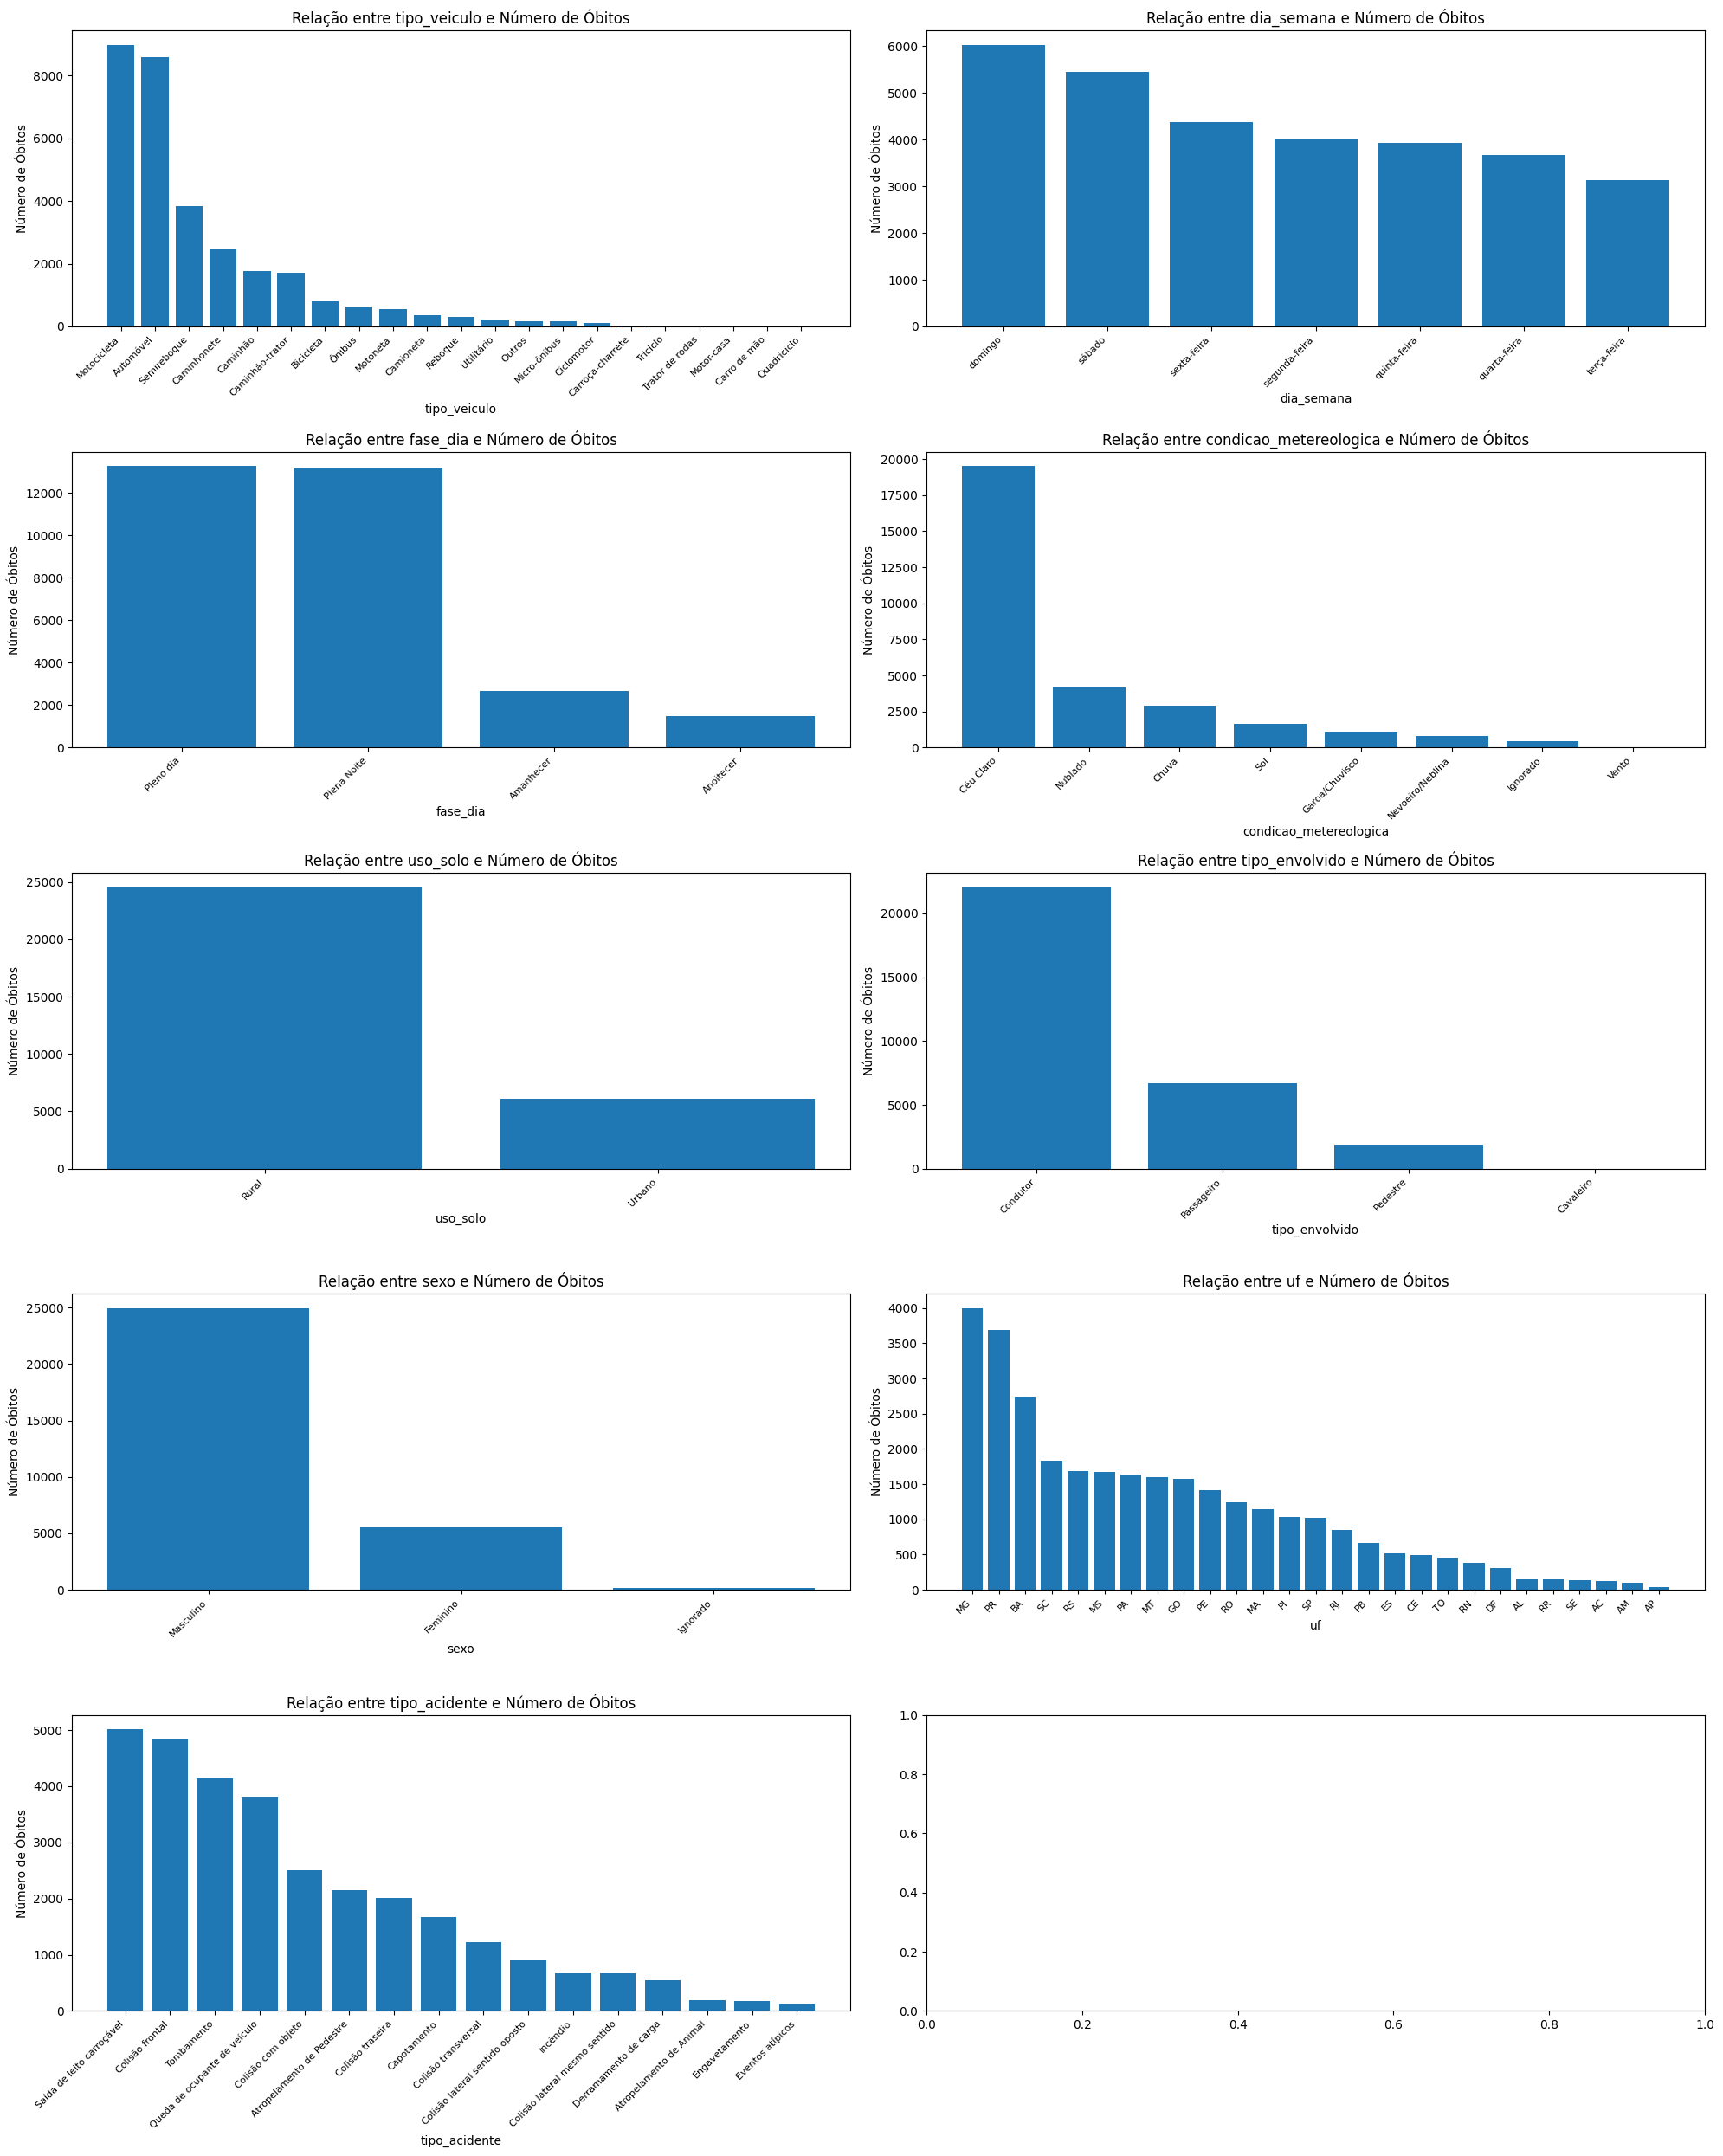

In [ ]:
#Criando subplots para variáveis categóricas

if n_vars_cat > 0:
    fig_cat, axes_cat = plt.subplots(nrows=n_rows_cat, ncols=n_cols, figsize=(20, 5 * n_rows_cat))
    if n_rows_cat > 1:
        axes_cat = axes_cat.flatten()
    else:
        axes_cat = [axes_cat] if n_vars_cat > 0 else []

    # Loop para percorrer as variáveis categóricas e criar um gráfico de dispersão ou linha para cada uma
    for i, var in enumerate(categorical_vars):
        ax = axes_cat[i]

        grouped_data = df_obito.groupby(var)['estado_fisico'].count().reset_index()

        grouped_data = grouped_data.sort_values(by='estado_fisico', ascending=False)

        x_positions = np.arange(len(grouped_data[var]))

        ax.bar(x_positions, grouped_data['estado_fisico'])
        ax.set_xlabel(var);
        ax.set_ylabel('Número de Óbitos')
        ax.set_title(f'Relação entre {var} e Número de Óbitos')

        ax.set_xticks(x_positions)
        ax.set_xticklabels(grouped_data[var], rotation=45, fontsize=8, ha='right')

    plt.tight_layout()
    plt.show()

**Insights**

*   Variável target: A variável target está desbalanceada, demandando técnicas para contornar esta situação e não enviezar o modelo.
*   Tipo de Veículos: No ano de 2023 os acidentes nas rodovias e estradas brasileiras que resultaram em óbitos, teve mais da metade dos acidentes concentrados em motos, carros e caminhões(e similares). O Brasil depende muito de caminhões e similares para uso logistico, por isso há muitos caminhões rodando pelo Brasil. Por vezes em rodovias sinuosas e sem iluminação adequada, o que contribui para um acidente. Motos e carros são dois dos veículos mais usados pelos brasileiros o que justifica sua presença neste gráfico. Não é absurdo pensar que num acidente uma moto e um carro estejam envolvidos.
*   dia da semana: O fim de semana aparece como os dias em que ocorreram mais acidentes em 2023. São dias que as pessos utilizam mais os veículos para se dirigir a estabelecimentos como restaurantes e bares, onde, um existe um eventual consumo de álcool.
*   Fase dia: Pleno dia não fica muito claro qual o horário que começa ou termina, mas é plausível pensar que existem horários de pico com alta circulação de veículos e pedestres, onde um acidente fatal pode vir a acontecer. Plena noite pode ser explicada por falta de iluminação em estradas e rodovias
*   Céu claro: Um consenso comum é pensar que em dias chuvosos um acidente é mais suscetivel. Mas em 2023 os acidentes em dias chuvosos e nublados se somados representam uma parcela pequena se comparados a acidentes em dias de céu claro.
*   Tipo envolvido: A maioria dos óbitos em acidentes foram de condutores, podendo indicar que os condutores não possuem tantas preocupações com cintos quanto os passageiros
*   Sexo: O sexo masculino pode ter sido mais imprudente ao volante do que o sexo feminino
*   Os Três estados da região sul do país aparecem no top 4 de estados com mais acidentes. Pode ser explicado pela BR-101 que frequentemente aparece como uma das mais periosas em listas especializadas.

*   Tipo acidente: Acidentes em que o carro sai da pista e de colisão frontal são acidentes comuns em pistas má iluminadas e à noite, o que corrobora com os dados da fase do dia












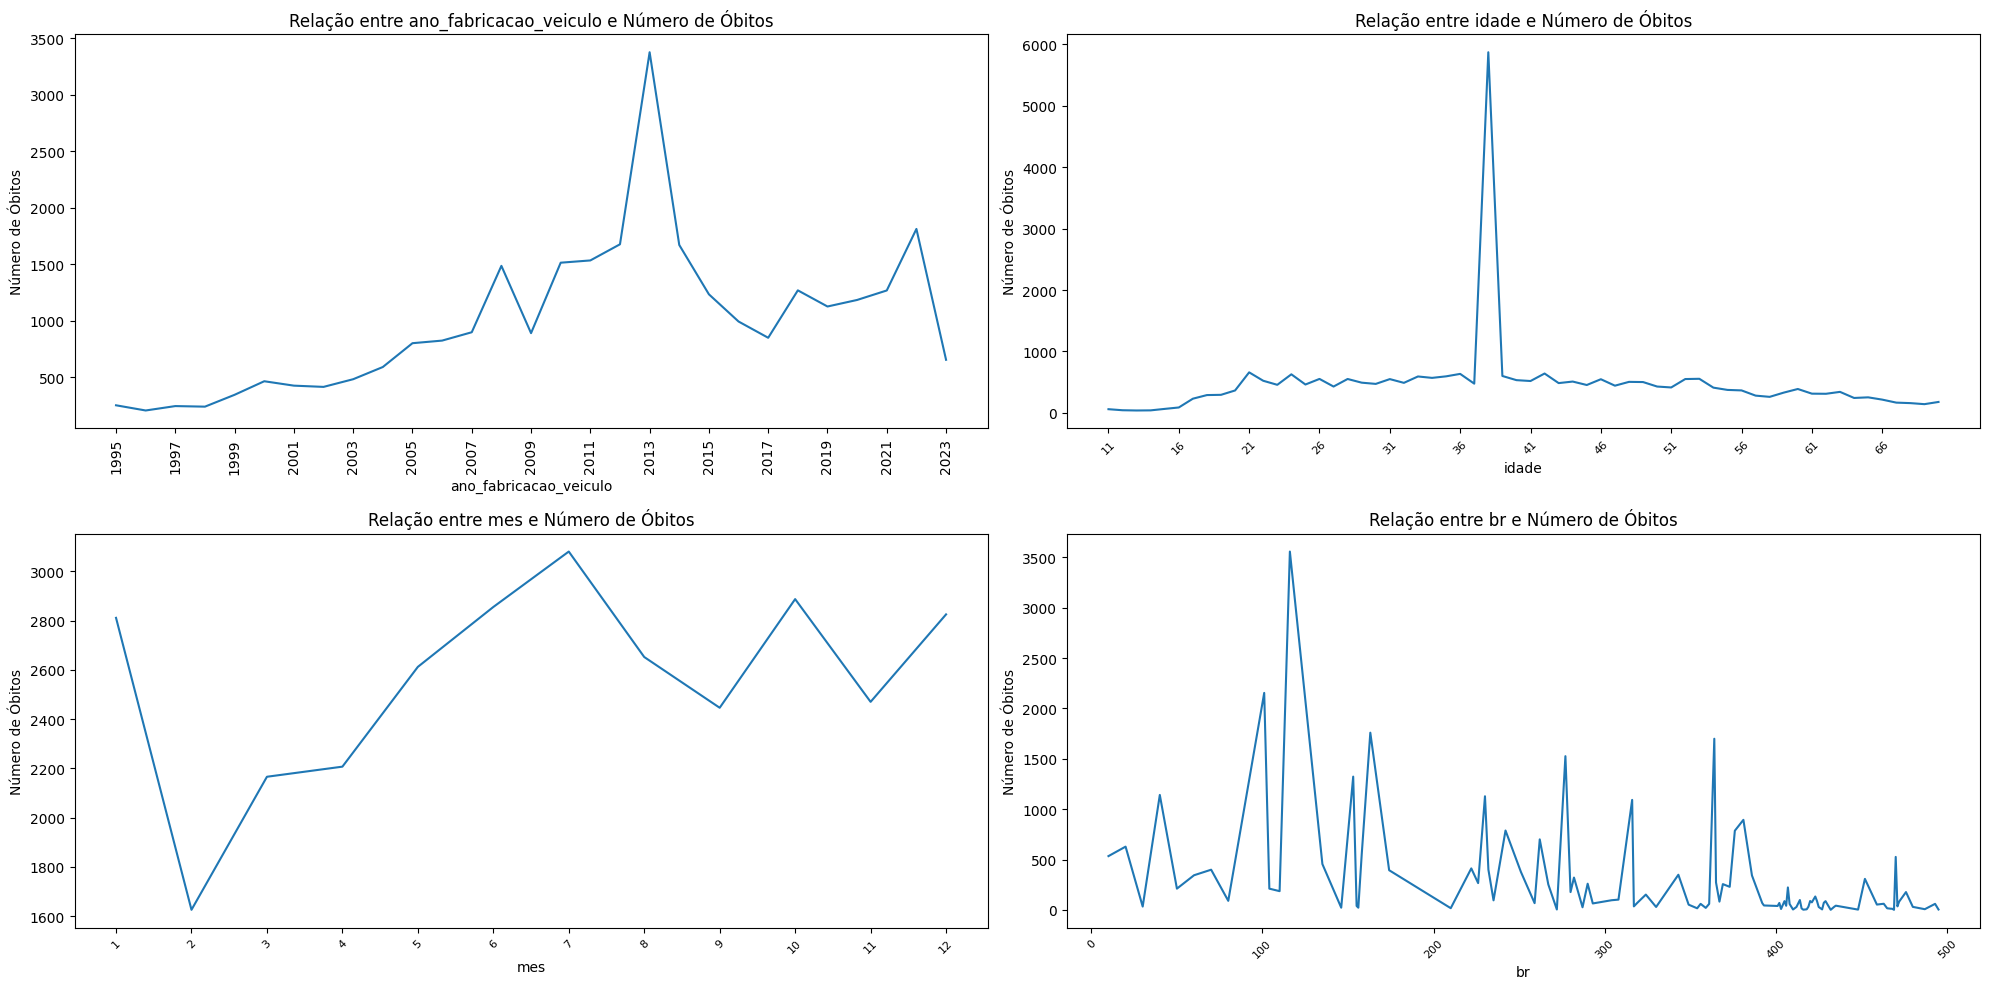

In [ ]:
# Criando subplots para variáveis numéricas
if n_vars_num > 0:
    fig_num, axes_num = plt.subplots(nrows=n_rows_num, ncols=n_cols, figsize=(20, 5 * n_rows_num))
    if n_rows_num > 1:
        axes_num = axes_num.flatten()
    else:
        axes_num = [axes_num] if n_vars_num > 0 else []

    # Loop para percorrer as variáveis numéricas e criar um gráfico de dispersão ou linha para cada uma
    for i, var in enumerate(numerical_vars):
        ax = axes_num[i] 

        # Agrupando os dados fltrados e calculando a contagem de 'estado_fisico' (Óbito)
        grouped_data = df_obito.groupby(var)['estado_fisico'].count().reset_index()

        # Para 'mes' e 'ano_fabricacao_veiculo', sejam representados
        if var == 'mes':
            all_months = pd.DataFrame({'mes': range(1, 13)})
            grouped_data = all_months.merge(grouped_data, on='mes', how='left').fillna(0)
            ax.plot(grouped_data[var], grouped_data['estado_fisico'])
            ax.set_xticks(range(1, 13))
        elif var == 'ano_fabricacao_veiculo':
             
            all_years = pd.DataFrame({'ano_fabricacao_veiculo': df['ano_fabricacao_veiculo'].dropna().unique()})
            grouped_data = all_years.merge(grouped_data, on='ano_fabricacao_veiculo', how='left').fillna(0)
            grouped_data = grouped_data.sort_values(by='ano_fabricacao_veiculo')
            ax.plot(grouped_data[var], grouped_data['estado_fisico'])
            ax.tick_params(axis='x', rotation=90) 
            
            min_year = int(grouped_data[var].min())
            max_year = int(grouped_data[var].max())
            ax.set_xticks(range(min_year, max_year + 1, 2))

        elif var == 'idade':
            
            ax.plot(grouped_data[var], grouped_data['estado_fisico'])
            
            min_idade = int(grouped_data[var].min())
            max_idade = int(grouped_data[var].max())
            ax.set_xticks(range(min_idade, max_idade + 1, 5))
        else:
            
            ax.plot(grouped_data[var], grouped_data['estado_fisico'])

        ax.set_xlabel(var);
        ax.set_ylabel('Número de Óbitos');
        ax.set_title(f'Relação entre {var} e Número de Óbitos')
        if var != 'ano_fabricacao_veiculo':
             ax.tick_params(axis='x', rotation=45, labelsize=8); 


    
    plt.tight_layout()
    plt.show()

* ano_fabricacao_veiculo: Os véiculos com ano entre 2012 e 2014 aparecem com um percentil maior. Um fenomeno que eu não saberia explicar, precisaria de mais dados para analisar. Mas é interessante porque, carros com anos de fabricação anteriores e posteriores a este intervalo, contribuem muito pouco para o número de acidentes. Será que à partir de um determinado tempo de fabricação ele tem grandes chances de estar envolvido em um acidente? E se ele passar por está espécie de filtro, ele tem poucas chances? Precisaria de mais dados para verificar se este comportamento é fruto de uma casualidade. Fato é, que a curva é crescente se comparado com os anos antes de 2000.

* idade: Novamente, uma curva muito parecida com a dos veículos, um inervalo muito especifico de idades, condensa a maior parte dos acidentes, enquanto o restante forma duas caudas pouco representativas. Formato semelhante a uma distribuição normal.

* mes: À partir de abril o número de acidentes cresce e tem o seu pico entre os meses de junho e julho, o mesmo período de férias escolares, onde ocorrem mais viagens. No fim do ano, entre dezembro e janeiro, tem um novo pico, provavelmente devido às festas de fim de ano. Curiosamente, em fevereiro apresenta um vale, que não se repete no gráfico


In [ ]:
df[df['mortos'] == 1].groupby('br').size()

,0
br,
10.0,534
20.0,628
30.0,33
40.0,1141
50.0,211
...,...
476.0,177
480.0,30
487.0,7


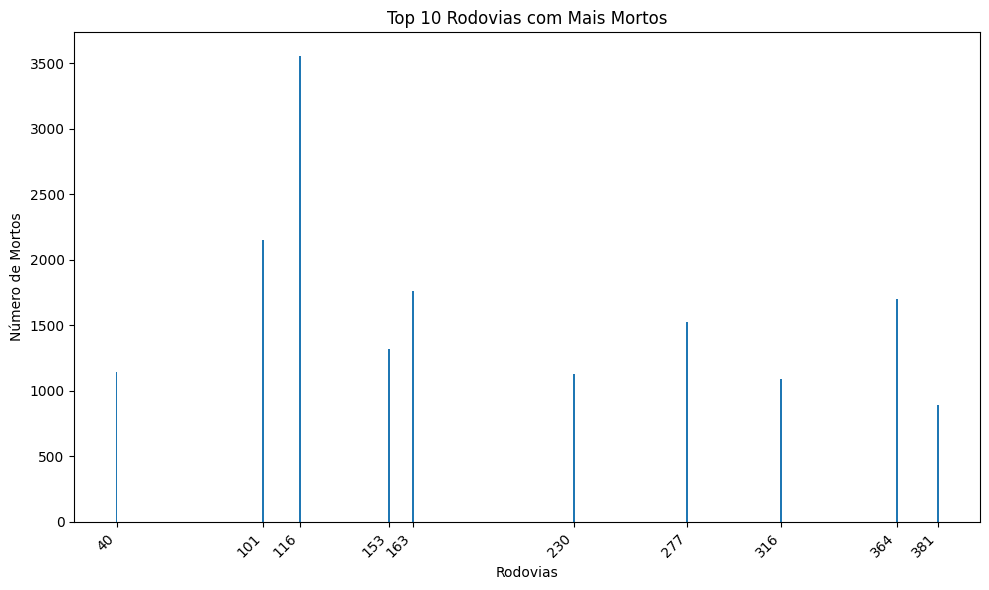

In [ ]:
# Agrupa os dados por 'br' e soma os 'mortos', ordenando em ordem decrescente
grouped_data = df.groupby('br')['mortos'].sum().sort_values(ascending=False).reset_index()

# Seleciona as 5 primeiras linhas (top 5)
top_10_br = grouped_data.head(10)

# Cria o gráfico de barras com as top 5 BRs
plt.figure(figsize=(10, 6))
plt.bar(top_10_br['br'], top_10_br['mortos'])
plt.xlabel('Rodovias')
plt.ylabel('Número de Mortos')
plt.title('Top 10 Rodovias com Mais Mortos')

# Define os ticks do eixo x com as BRs do top_5_br
plt.xticks(top_10_br['br'], rotation=45,ha='right')

plt.tight_layout()
plt.show()

In [ ]:
top_10_br

,br,mortos
0,116.0,3557.0
1,101.0,2154.0
2,163.0,1759.0
3,364.0,1699.0
4,277.0,1526.0
5,153.0,1323.0
6,40.0,1141.0
7,230.0,1128.0
8,316.0,1092.0
9,381.0,894.0


# Encoding e modelagem

In [2]:
import sklearn as sk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
features = ['tipo_veiculo', 'dia_semana','fase_dia', 'condicao_metereologica','tipo_envolvido', 'uso_solo','sexo','idade', 'tipo_acidente','ano_fabricacao_veiculo','mes', 'uf']

In [ ]:
df = df.drop(columns=['tracado_via','marca','estado_fisico', 'br'])

In [ ]:
df_encoded = pd.get_dummies(df, columns=features, prefix=features, drop_first=True, dummy_na=False)

In [ ]:
df_encoded.head()

,mortos,tipo_veiculo_Bicicleta,tipo_veiculo_Caminhonete,tipo_veiculo_Caminhão,tipo_veiculo_Caminhão-trator,tipo_veiculo_Camioneta,tipo_veiculo_Carro de mão,tipo_veiculo_Carroça-charrete,tipo_veiculo_Chassi-plataforma,tipo_veiculo_Ciclomotor,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,0.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
features= df_encoded[[col for col in df_encoded.columns if any(f in col for f in features)]]


In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(features, target, test_size=0.2, random_state=42)

#Um print mostrando a divisão
print("Dados de x_treino",len(x_treino))
print("Dados de x_teste",len(x_teste), end='\n\n')

print("Dados de y_treino",len(y_treino))
print("Dados de y_teste",len(y_teste))

Dados de x_treino 455372
Dados de x_teste 113844

Dados de y_treino 455372
Dados de y_teste 113844


In [ ]:
x_treino.columns = x_treino.columns.astype(str)
ros = RandomOverSampler(random_state=0)
x_treino_ros, y_treino_ros = ros.fit_resample(x_treino, y_treino)

valores_unicos, contagem = np.unique(y_treino_ros, return_counts=True)

for valor, quantidade in zip(valores_unicos, contagem):
    print(f"Valor {valor}: {quantidade} vezes")

Valor 0.0: 430943 vezes
Valor 1.0: 430943 vezes


In [ ]:
modelo_preditor = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
modelo_preditor.fit(x_treino_ros, y_treino_ros)

RandomForestClassifier(random_state=42)

In [ ]:
predicao = modelo_preditor.predict(x_teste)

In [ ]:
confusion_matrix(y_teste, predicao)

array([[107301,    335],
       [   979,   5229]])

In [ ]:
print(classification_report(y_teste, predicao))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    107636
         1.0       0.94      0.84      0.89      6208

    accuracy                           0.99    113844
   macro avg       0.97      0.92      0.94    113844
weighted avg       0.99      0.99      0.99    113844



Para calcular o custo por óbito, foi considerado o relatório “CUSTOS DOS ACIDENTES DE TRÂNSITO NO BRASIL: ESTIMATIVA SIMPLIFICADA COM BASE NA ATUALIZAÇÃO DAS PESQUISAS DO IPEA SOBRE CUSTOS DE ACIDENTES NOS AGLOMERADOS URBANOS E RODOVIAS” (CARVALHO, 2020). Neste relatório, é apresentado atualizações das pesquisas de custos dos acidentes de trânsito no brasil.

Para este trabalho, será considerado o custo de acidentes na rodovias federais, presente na Tabela 1 - Custos médios por componente elementar de custo segundo a gravidade do acidente.

Em 2014 o custo em caso de óbito em rodovias federais era de R$433.286,69

Utilizando a calculadora do cidadão, calculei o valor de correção do IPCA de 12/2014 até 10/2024. Obtemos o valor 2,14471250.

Fazendo a correção, daria R$ 929.365,42  

Relatório utilizado
https://www.ipea.gov.br/portal/images/stories/PDFs/TDs/td_2565.pdf

Calculadora do cidadão
https://www3.bcb.gov.br/CALCIDADAO/publico/exibirFormCorrecaoValores.do?method=exibirFormCorrecaoValores

Definição de Saída de Leito Carroçável
https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/diest-arquivos/copy_of_anuario-2021_final.html#:~:text=Sa%C3%ADda%20de%20leito%20carro%C3%A7%C3%A1vel%3A%20evento,%C3%A2ngulo%20menor%20que%20180%C2%B0

Conjunto de dados
https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf